In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os 
if not os.path.exists('figures'):
    os.makedirs('figures')
    
sns.set_style('whitegrid')

!nvidia-smi

Wed Apr 17 10:04:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:E3:00.0 Off |                    0 |
| N/A   25C    P0              52W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [64]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-5, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if (abs(f(x_next)) < abs_tol) or (abs(f(x_next)) < rel_tol * gf(x)):
            return x_next
        x = x_next
    return None

def solve_kappa(q, lamb, etaX, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  if lamb == 0 and q <= 1:
    return 0
  if lamb == 0 and q > 1:
    fn = lambda kappa: 1 - q * df_1(etaX, kappa)
    return newton(fn, x0=0.0, **kwargs)
  
  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: kappa * (1 - q * df_1(etaX, kappa)) - anneal_lamb
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next: 
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  return kappa

def estimate_df1(lamb, X_tr):
  P, D = X_tr.shape
  q = D/P
  if q >= 1:
    gram = X_tr @ X_tr.T / P
    return jnp.trace(jnp.linalg.solve(gram + lamb*np.identity(P), gram)) / D
  else:
    cov = X_tr.T @ X_tr / P
    return jnp.trace(jnp.linalg.solve(cov + lamb*np.identity(D), cov)) / D

def estimate_df1_S(lamb, X_tr):
  P, D = X_tr.shape
  q = D/P
  if q >= 1:
    gram = X_tr @ X_tr.T / P
    df1 = jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)) @ gram)/D
    S = (lamb * jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)))/P)**(-1)
    return df1, S
  else:
    cov = X_tr.T @ X_tr / P
    df1 = jnp.trace(jnp.linalg.inv(cov + lamb*np.identity(D)) @ cov)/D
    S = 1/(1-q * df1) 
    return df1, S

In [68]:
def simulate_theory(D, qs, lambs, sigma_epsilon, spectrum, teacher, X_te, y_te, num_X_seeds):
    if type(lambs) != list:
        lambs = [lambs]*len(qs)
    data = {}
    S = jnp.diag(spectrum)
    for i in tqdm(range(len(qs))):
        q, lamb  = qs[i], lambs[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, X_te.shape[0]))
        df1_empirical = np.zeros(num_X_seeds)
        kappa_GCV = np.zeros(num_X_seeds)
        Etrs = np.zeros(num_X_seeds)
        for X_seed in range(num_X_seeds):
            key = random.PRNGKey(X_seed)
            X_tr_key, e_key = random.split(key)
            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ (S**0.5)
            y_tr = X_tr @ teacher + epsilon
            y_tr_clean = X_tr @ teacher

            if P > D:
                cov = X_tr.T @ X_tr/P
                w_star = jnp.linalg.solve(cov + lamb*np.identity(D), X_tr.T @ y_tr/P)
                w_star_clean = jnp.linalg.solve(cov + lamb*np.identity(D), X_tr.T @ y_tr_clean/P)
                y_hat_tr = X_tr @ w_star
                Etrs[X_seed] = jnp.mean((y_tr - y_hat_tr)**2)
            else: 
                gram = X_tr @ X_tr.T/P
                w_star = X_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr)/P
                w_star_clean = X_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr_clean)/P
                Etrs[X_seed] = lamb**2/P * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(P), y_tr))**2)

            y_hats[X_seed, :] = X_te @ w_star
            y_hats_clean[X_seed, :] = X_te @ w_star_clean    
            
            df1_emp, S_emp = estimate_df1_S(lamb, X_tr)
            df1_empirical[X_seed] = df1_emp
            kappa_GCV[X_seed] = lamb * S_emp

        Eg = np.mean((y_hats - y_te[None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias = np.mean((y_te - np.mean(y_hats_clean, axis=0))**2)
        VarX = np.mean((y_hats_clean - y_te[None, :])**2, axis=-1) - Bias
        VarXe = Noise
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': Noise,
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT


def solve_theory(qs, lambs, sigma_epsilon, spectrum, teacher, anneal_steps=0, **kwargs):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    upper_bounds = lambs + np.mean(spectrum)*qs
    kappa = jnp.array([solve_kappa(q, lamb, spectrum, 
                        anneal_steps=anneal_steps, upper_bound=bd, **kwargs) 
                        for q, lamb, bd in zip(qs, lambs, upper_bounds)])
    df1 = jnp.array([df_1(spectrum, k) for k in kappa])
    Ss = jnp.array([1/(1-q*df_1(spectrum, k)) for q,k in zip(qs, kappa)])
    Ss = jnp.where((lambs == 0) & (qs > 1), jnp.inf, Ss)
    df2 = jnp.array([df_2(spectrum, k) for k in kappa])
    tf1p = jnp.array([tf_1p(spectrum, teacher, k) for k in kappa])
    gamma = qs * df2
    
    bias = kappa**2 * tf1p
    varX = kappa**2 * tf1p * gamma/(1-gamma)
    noise = sigma_epsilon**2 * gamma/(1-gamma)
    signal = bias + varX
    Eg = signal + noise
    Etr = (1/Ss)**2 * (Eg + sigma_epsilon**2)
    data = {
        'kappa': kappa,
        'df1': df1,
        'S': Ss,
        'df2': df2,
        'tf1p': tf1p,
        'gamma': gamma,
        'Bias': bias,
        'VarX': varX,
        'VarXe': noise,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

## Unstructured Linear Regression

In [69]:
D = 250
P_te = 100
qs = np.logspace(-2, 2, 21)
qs2 = jnp.logspace(-2, 2, 21)
lamb = 1e-4
sigma_epsilon = 0.5
num_seeds = 50

etas = jnp.arange(1, D+1)**(0)
S = jnp.diag(etas)
w = jnp.arange(1, D+1)**(0)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(42)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=5, abs_tol=1e-3)

100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


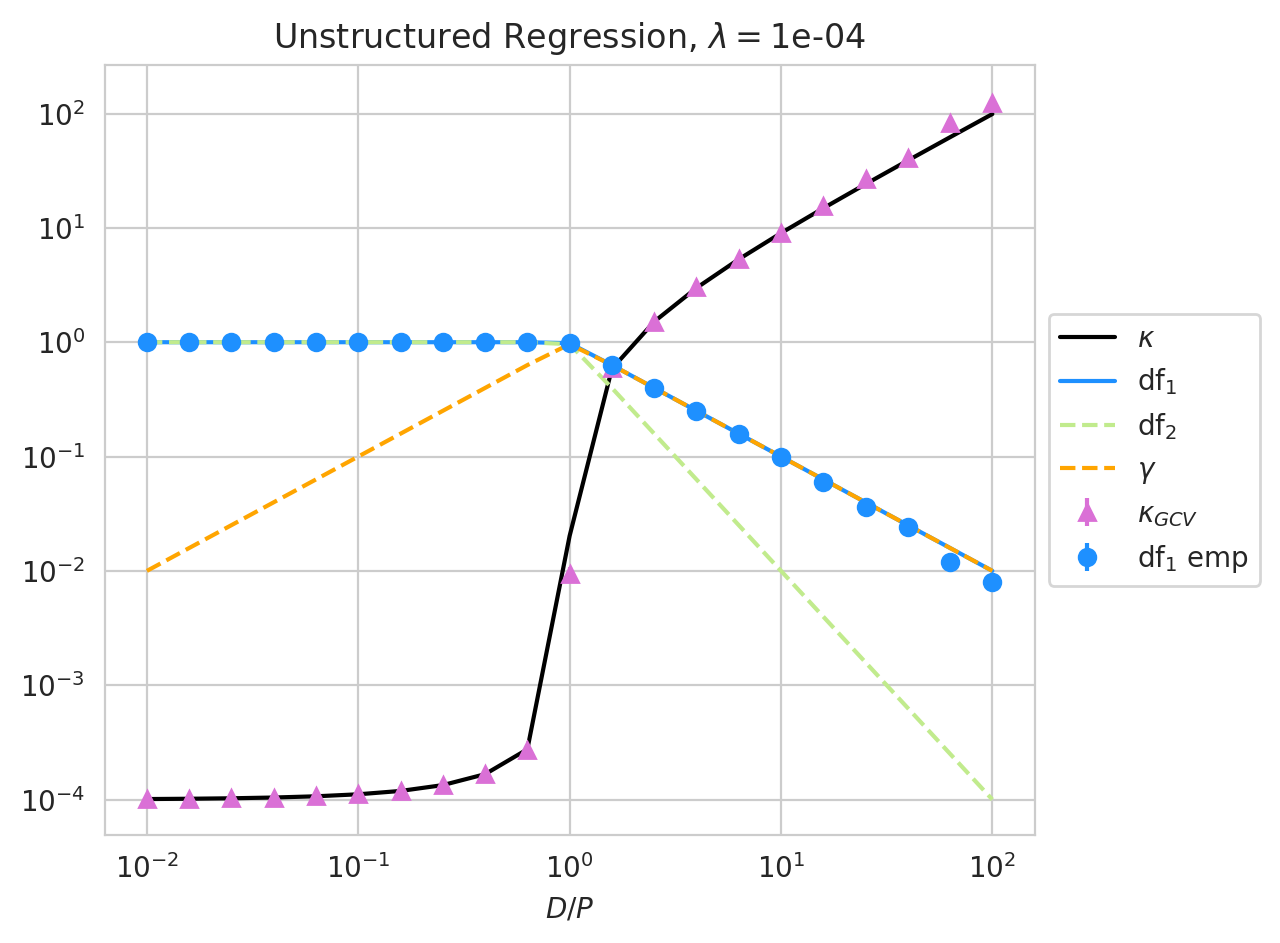

In [70]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa'], label="$\\kappa$", c='k')
plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(qs2, thry['df1'], label="df$_1$", c='dodgerblue')
plt.errorbar(qs, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')
plt.plot(qs2, thry['df2'], label="df$_2$", c='C4', ls='--')
plt.plot(qs2, thry['gamma'], label="$\\gamma$", c='orange', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$D/P$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/unstructured_LR_params.pdf', bbox_inches='tight')

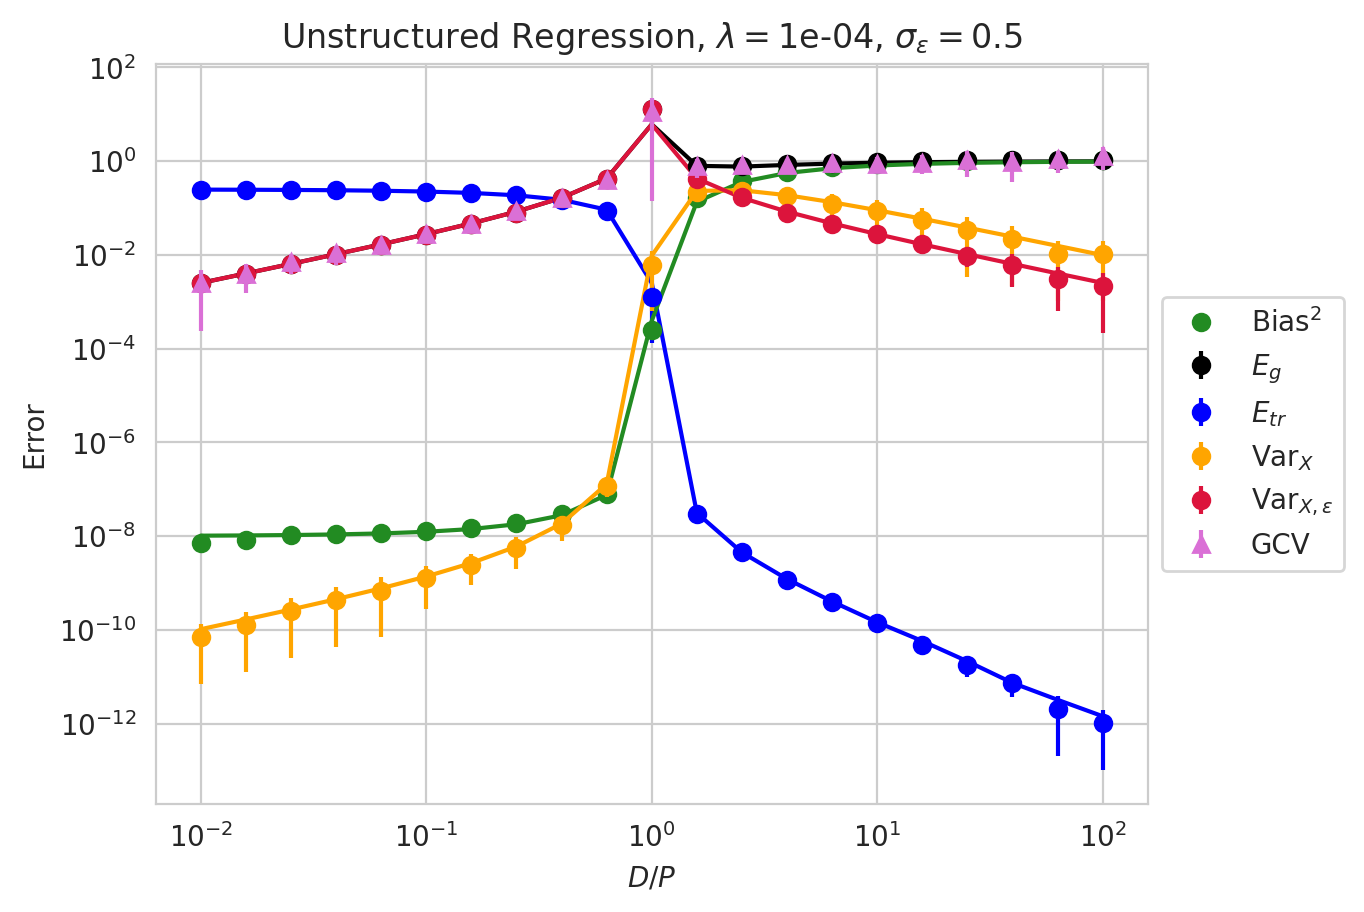

: 

In [71]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(qs, E_GCV, E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$D/P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-7,2)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig
plt.savefig('figures/unstructured_LR_logspace.pdf', bbox_inches='tight')

In [28]:
lamb = 1e-3
sigma_epsilon = 0.5
qs =  1/np.linspace(0.1, 2.0, 20)
qs2 = 1/np.linspace(0.05, 2.0, 40)
expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=5, abs_tol=1e-5)

100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


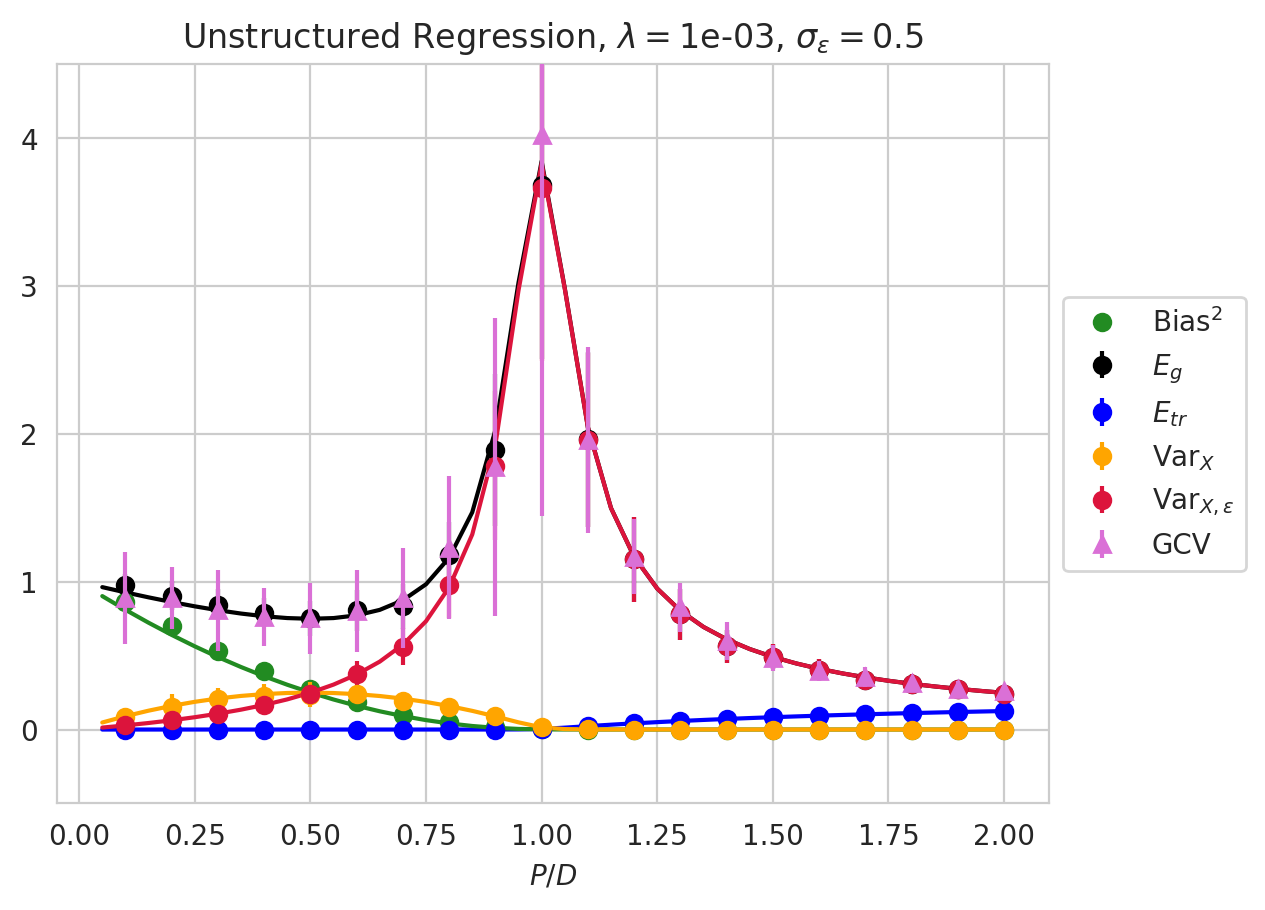

In [29]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], expt[key+'_std'], c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

plt.errorbar(1/qs, (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2, (expt['kappa_GCV']/lamb)**2 * expt['Etr_std'], c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P/D$')
plt.ylim(-0.5, 4.5)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/unstructured_LR_linspace.pdf', bbox_inches='tight')

## Structured Linear Regression

In [55]:
D = 10_000
num_seeds = 30

qs = np.logspace(1, 4, 20)
qs2 = qs

# Source and capacity exponents
r = 0.5
alpha = 1.1

sigma_epsilon = 0.0
lamb = 1e-4
etas = jnp.arange(1, D+1)**(-alpha)
S = jnp.diag(etas)
w = jnp.arange(1, D+1)**(-(1 + alpha * (2*r - 1))/2)
w = w / jnp.sqrt(jnp.sum(w**2))

P_te = 200
X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=4)

100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


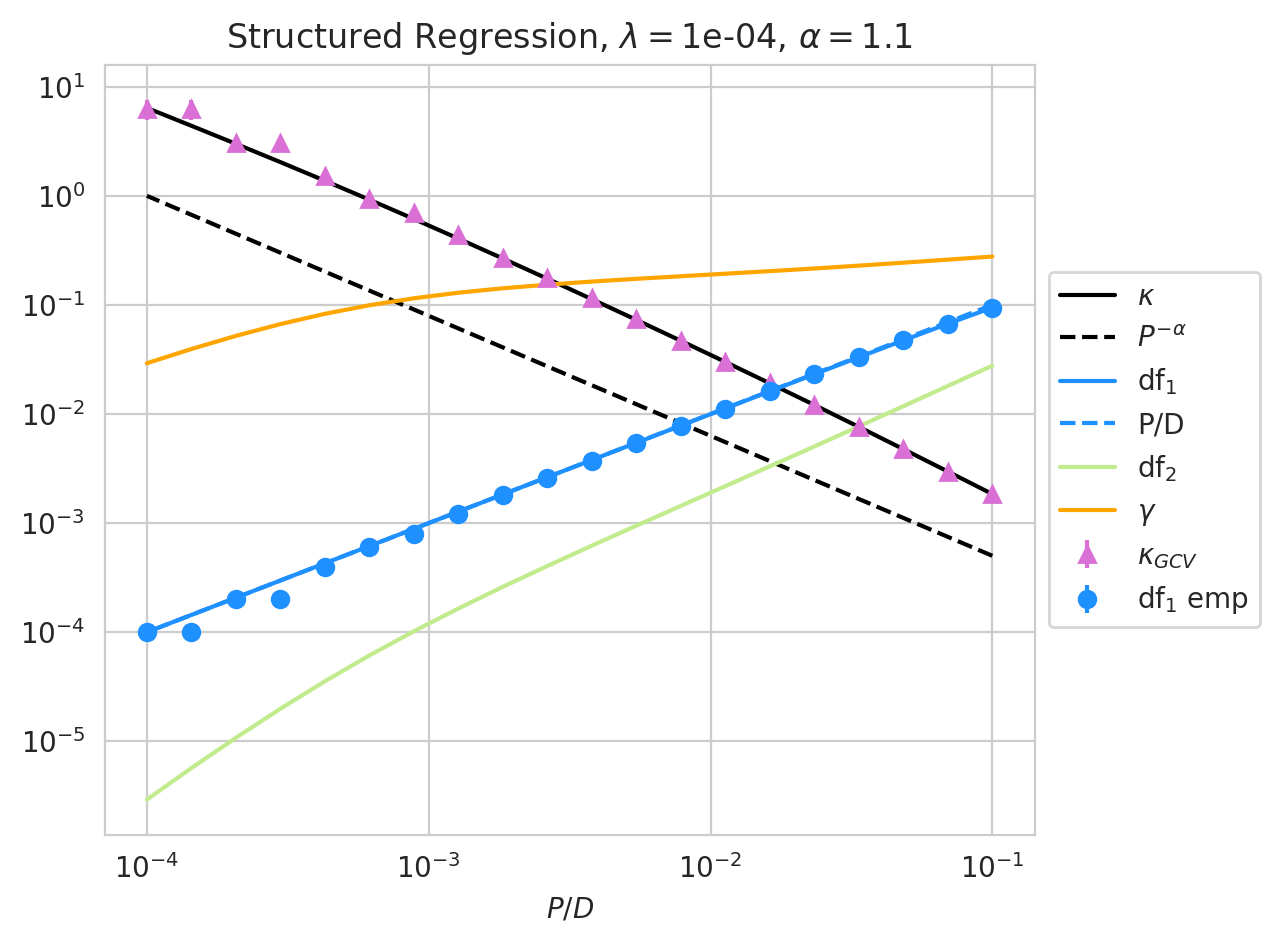

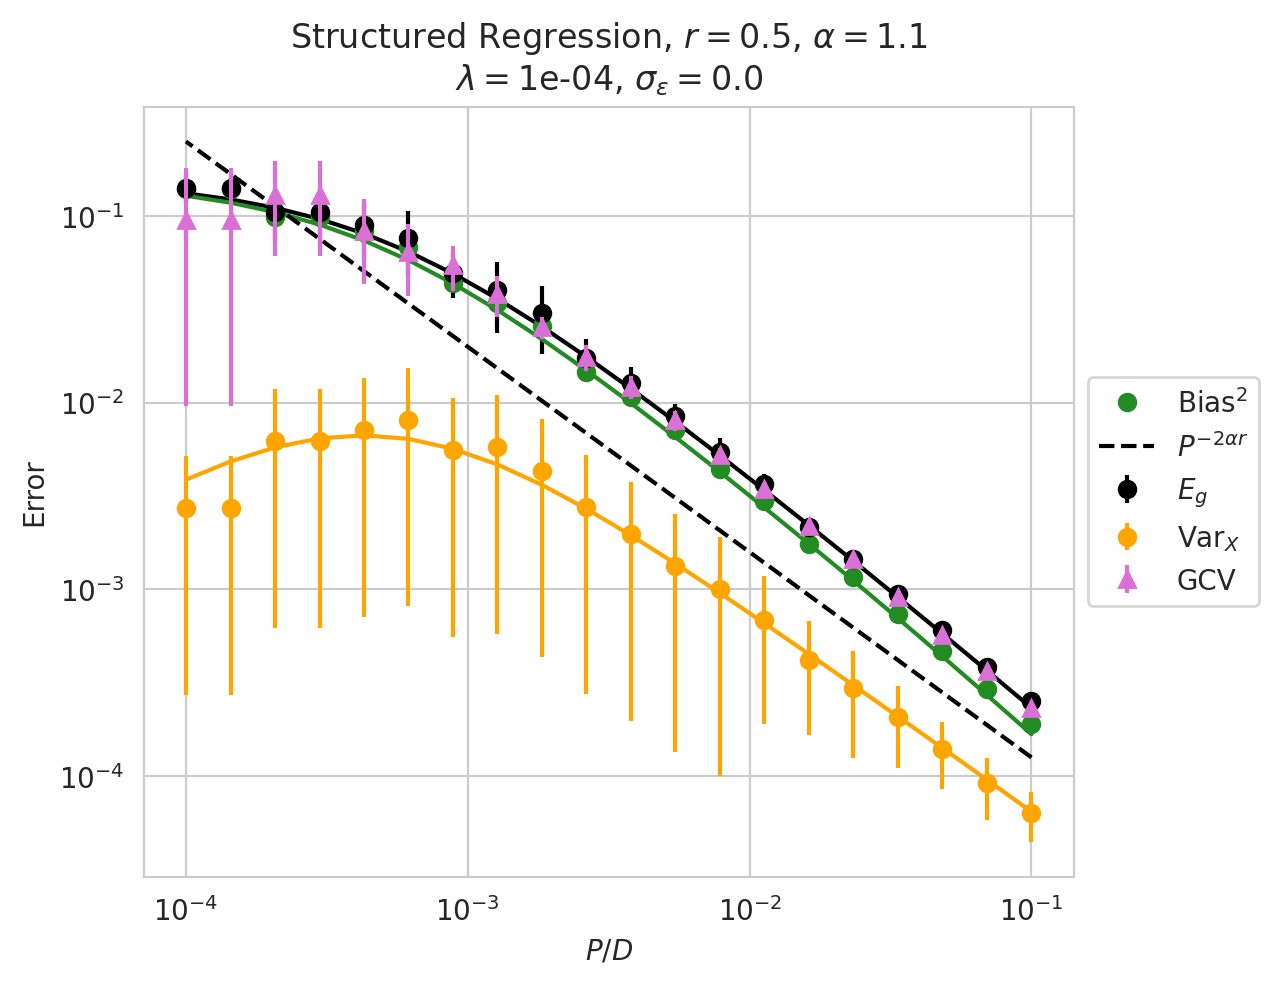

In [58]:
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa'], label="$\\kappa$", c='k')
plt.plot(1/qs2, 1e0*(qs2/D)**(alpha), c='black', linestyle='--', label='$P^{{-\\alpha}}$')

plt.errorbar(1/qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(1/qs2, thry['df1'], label="df$_1$", c='dodgerblue')
plt.plot(1/qs2, 1/qs2, label="P/D", c='dodgerblue', ls='--')
plt.errorbar(1/qs2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')
plt.plot(1/qs2, thry['df2'], label="df$_2$", c='C4')
plt.plot(1/qs2, thry['gamma'], label="$\\gamma$", c='orange')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P/D$')
plt.title(f"Structured Regression, $\\lambda=${lamb:.0e}, $\\alpha=${alpha}")
plt.savefig('figures/structured_LR_params1.pdf', bbox_inches='tight')

plt.show()

plt.figure(figsize=(6, 5))
keys = ['Eg', 'Bias', 'VarX']
colors = ['k',  'forestgreen', 'orange']
labels = ["$E_g$", "Bias$^2$", "Var$_X$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

Eg_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
S = expt['kappa_GCV']/lamb
plt.errorbar(1/qs, S**2 * expt['Etr'] - sigma_epsilon**2, np.minimum(S**2 * expt['Etr_std'], 0.9*Eg_GCV), c='orchid', marker='^', linestyle='', label='GCV', zorder=3)
lbl = '$P^{{-2\\alpha}}$' if r > 1 else '$P^{{-2\\alpha r}}$'
plt.plot(1/qs2, 1e-5*(qs2)**(2*alpha*min(r, 1)), c='black', linestyle='--', label=lbl)

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(8e-5, 8e-2)
plt.title(f"Structured Regression, $r=${r}, $\\alpha=${alpha}\n$\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/structured_LR_source.pdf', bbox_inches='tight')

## Gapped Linear Regression

In [59]:
D = 10_110

qs = np.logspace(1, 4, 20)
Ps = D/qs
qs2 = qs

b = 0
a = 0
num_seeds = 30

sigma_epsilon = 0.0
lamb = 1e-8
D1 = 10
D2 = 100
D3 = 10000
e1, e2, e3 = 1e0, 1e-2, 1e-5
w1, w2, w3 = 1, 1e1, 1e2
etas = np.array([e1]*D1 + [e2]*D2 + [e3]*D3) 
S = jnp.diag(etas)
w = np.array([w1]*D1 + [w2]*D2 + [w3]*D3)
w = 1e2 * w / jnp.sqrt(jnp.sum(w**2))

P_te = 200
X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=2)

100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


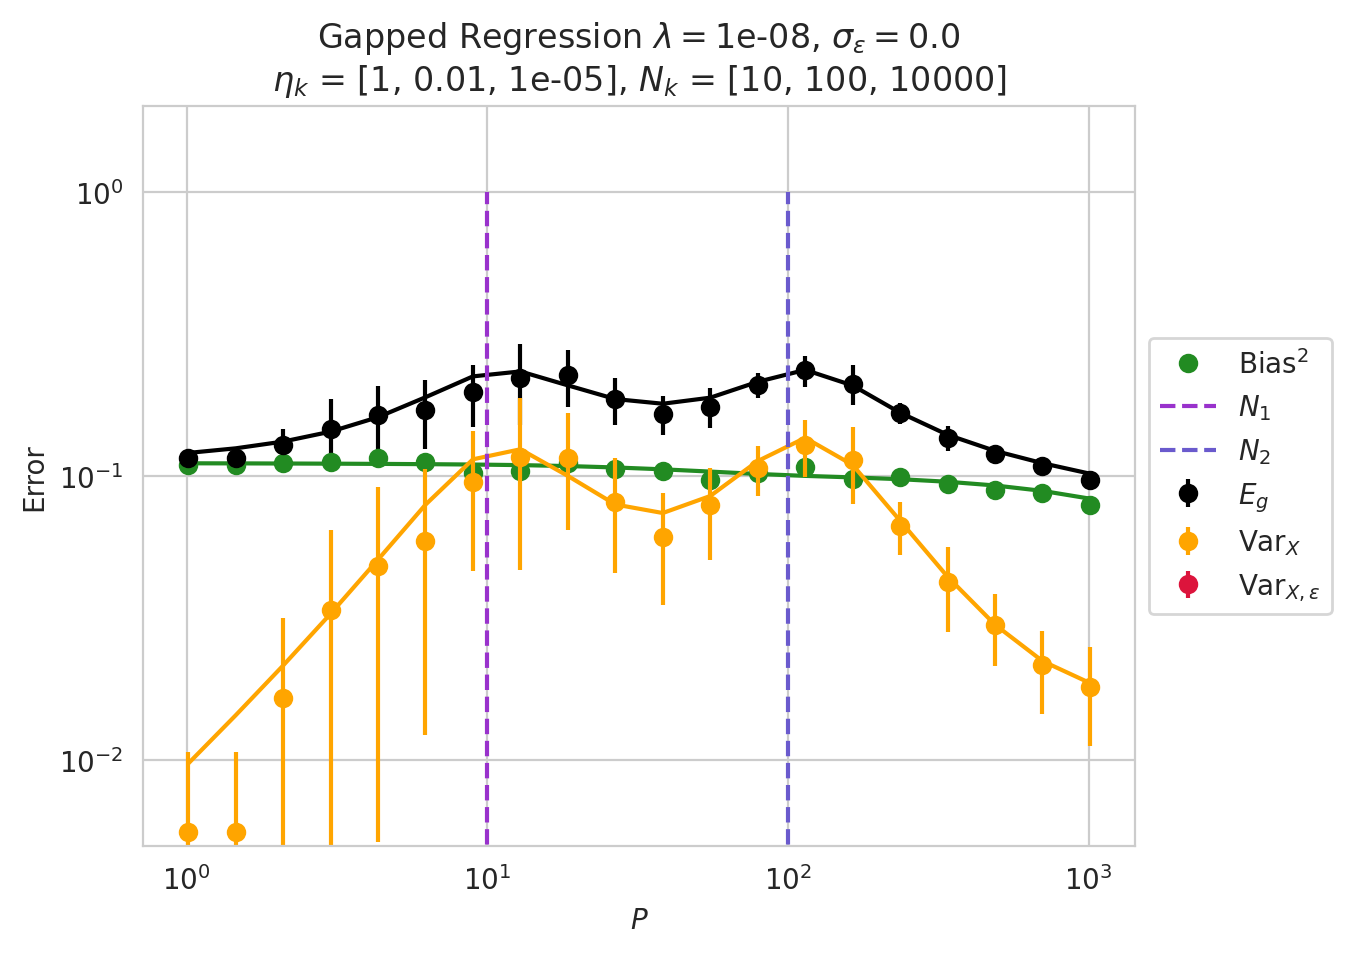

In [60]:
keys = ['Eg',  'Bias', 'VarX', 'VarXe']
colors = ['k',  'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(D/qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(D/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(D/qs2, thry[key], c=color)


plt.plot([D1, D1], [0, 1], c='darkorchid', ls='--', label="$N_1$")
plt.plot([D2, D2], [0, 1], c='slateblue', ls='--', label="$N_2$")
# plt.plot(D/qs, (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2 , c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-3, 2e0)
plt.title(f"Gapped Regression $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}\n$\eta_k$ = [{e1:.0g}, {e2:.0g}, {e3:.0g}], $N_k$ = [{D1}, {D2}, {D3}]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/multiple_descent.pdf', bbox_inches='tight')